---
title: "3D DC Resistivity Inversion"
authors:
  - id: devincowan
---

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** DC resistivity, 3D inversion, weighted least-squares, tree mesh.

</br>

**Summary:** Here, DC resistivity data are inverted to recover a log-conductivity model using a weighted least-squares inversion approach. Most of the functionality required for this tutorial was presented in the [3D Forward Simulation](fwd_dcr_3d.ipynb) and [2.5D Inversion](inv_dcr_2d.ipynb) tutorials. We strongly urge the reader to work through the aforementioned tutorials prior to working through this one, as we will avoid significant repitition of content.

</br>

**Learning Objectives:**

- Demonstrate 3D DC resistivity inversion with SimPEG.
- Discuss practical aspects of 3D DC resistivity inversion.
- Analyzing inversion outputs.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to DC resistivity is imported from [simpeg.electromagnetics.static.resistivity](xref:simpeg#simpeg.electromagnetics.static.resistivity).
We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](xref:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    convert_survey_3d_to_2d_lines,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip_xyz
from simpeg.utils import download, model_builder, get_default_solver
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

try:
    import plotly
    from simpeg.electromagnetics.static.utils.static_utils import plot_3d_pseudosection
    from IPython.core.display import display, HTML

    has_plotly = True
except ImportError:
    has_plotly = False
    pass

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import os
import tarfile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 16})

## Load Tutorial Data and Plot

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data and topography files are provided. Here, we download and import the observed data and topography into the SimPEG framework.

In [2]:
# URL to download from repository assets
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/05-dcr/inv_dcr_3d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
dc_data_filename = dir_path + "dc_data.xyz"

overwriting D:\Documents\Repositories\user-tutorials\notebooks\05-dcr\inv_dcr_3d_files.tar.gz
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\05-dcr\inv_dcr_3d_files.tar.gz
Download completed!


C:\Users\devin\AppData\Local\Temp\ipykernel_4368\2591142375.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


/tmp/ipykernel_974186/2591142375.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


### Load the Topography

Surface topography is defined as an (N, 3) [numpy.ndarray](xref:numpy#numpy.ndarray).

In [3]:
topo_xyz = np.loadtxt(str(topo_filename))

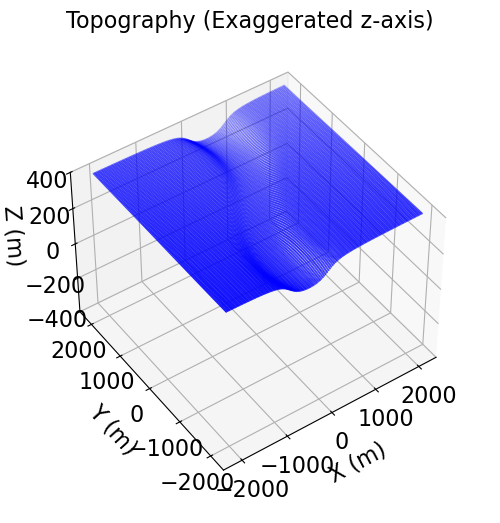

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection="3d")
ax.set_zlim([-400, 400])
ax.scatter3D(topo_xyz[:, 0], topo_xyz[:, 1], topo_xyz[:, 2], s=0.25, c="b")
ax.set_box_aspect(aspect=None, zoom=0.85)
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Z (m)", labelpad=10)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=-20)
ax.view_init(elev=45.0, azim=-125)

### Load DC Resistivity Data

**Option A: DCIP3D formatted data**

The [read_dcip3d_ubc](xref:simpeg#simpeg.utils.io_utils.read_dcip3d_ubc) utility function can be used to load DC/IP data stored in a UBC-GIF formatted file. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object.

**Option B: Load XYZ formatted data**

For this tutorial, the observed data are organized within an XYZ formatted file. We can use the [read_dcip_xyz](xref:simpeg#simpeg.utils.io_utils.read_dcip_xyz) utility function to load data in this format. This function outputs a SimPEG [Data](xref:simpeg#simpeg.data.Data) object. The data are normalized voltages in units V/A.

The `dict_headers` input argument can be used to import other data columns that are not required to define the SimPEG data object. In this case, we import a column that defines the survey line associated with each datum. We will use this to plot pseudosections for individual survey lines.

In [5]:
dc_data, out_dict = read_dcip_xyz(
    dc_data_filename,
    "volt",
    data_header="V/A",
    uncertainties_header="UNCERT",
    is_surface_data=False,
    dict_headers=["LINEID"],
)

### Plot Observed Data in 3D Pseudosection

Here we use the [plot_3d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_3d_pseudosection) utility function to represent the observed data in pseudosection. Although our original data are normalized voltages, we use the [apparent_resistivity_from_voltage](simpeg#simpeg.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities.

In [6]:
apparent_conductivities = 1 / apparent_resistivity_from_voltage(
    dc_data.survey,
    dc_data.dobs,
)

In [7]:
if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        apparent_conductivities,
        scale="log",
        units="S/m",
        marker_opts={"colorscale": "RdYlBu_r"},
    )

    fig.update_layout(
        title_text="Apparent Conductivity",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot Observed Data in 2D Pseudosection

As demonstrated in the [3D Forward Simulation](fwd_dcr_3d.ipynb) tutorial, we can parse the 3D survey into a set of 2D survey lines if we know which survey line is associated with each datum. Then we can plot individual pseudosections for each survey line. We use the [convert_survey_3d_to_2d_lines](simpeg#simpeg.electromagnetics.static.utils.convert_survey_3d_to_2d_lines) to generate the list of 2D surveys. And we use the [plot_2d_pseudosection](simpeg#simpeg.electromagnetics.static.utils.plot_2d_pseudosection) utility function to plot the pseudosection for the desired survey line.

In [8]:
# Extract line IDs and make sure they are integers
lineID = np.array(out_dict["LINEID"], dtype=int)

In [9]:
survey_2d_list, index_list = convert_survey_3d_to_2d_lines(
    dc_data.survey, lineID, data_type="volt", output_indexing=True
)

In [10]:
dobs_2d_list = []
apparent_conductivities_2d = []
for ind in index_list:
    dobs_2d_list.append(dc_data.dobs[ind])
    apparent_conductivities_2d.append(apparent_conductivities[ind])

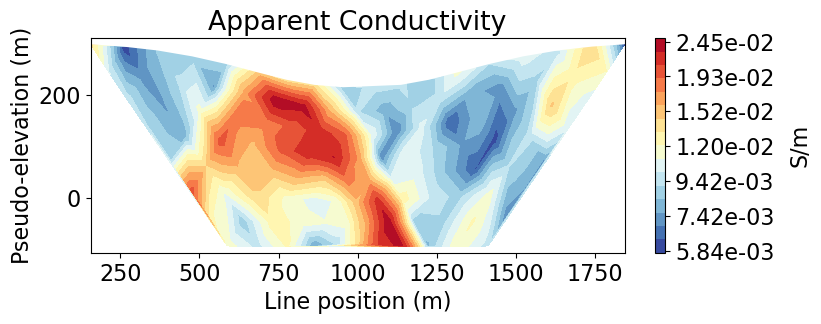

In [11]:
line_index = 0

fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey_2d_list[line_index],
    dobs=apparent_conductivities_2d[line_index],
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Conductivity")
plt.show()

## Assign Uncertainties

Approaches for applying reasonable uncertainties to normalized voltage and apparent resistivity data were presented in the [2.5D Inversion](inv_dcr_2d.ipynb) tutorial. Here, we apply uncertainties of 1e-7 V/A + 10 % to the normalized voltage data being inverted.

In [12]:
dc_data.standard_deviation = 1e-6 + 0.1 * np.abs(dc_data.dobs)

## Design a (Tree) Mesh

Please visit the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial to see the best practices for mesh design. The same rules for defining appropriate meshes for 2.5D simulations and inversion apply to 3D simulations and inversion.

**Tutorial mesh:** Here, a minimum cell width of 25 m (or 1/4 the minimum electrode spacing) is used within our survey region. The largest electrode spacing was 1000 m, so a the padding was extended at least 3000 m from the survey region. Using the [refine_surface](xref:discretize#discretize.TreeMesh.refine_surface) method, we refine the tree mesh where there is significant topography. And using the [refine_points](xref:discretize#discretize.TreeMesh.refine_points) methods, we refine based on electrodes locations. Visit the [tree mesh](xref:discretize#discretize.TreeMesh) API to see additional refinement methods.

In [13]:
# Defining domain size and minimum cell size
dh = 25.0  # base cell width
dom_width_x = 8000.0  # domain width x
dom_width_y = 8000.0  # domain width y
dom_width_z = 4000.0  # domain width z

# Number of base mesh cells in each direction. Must be a power of 2
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0="CCN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, 0.0, topo_xyz[:, -1].max()]

# Mesh refinement based on surface topography
k = np.sqrt(np.sum(topo_xyz[:, 0:2] ** 2, axis=1)) < 1200
mesh.refine_surface(topo_xyz[k, :], padding_cells_by_level=[0, 4, 4], finalize=False)

# Extract unique electrode locations.
unique_locations = dc_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(unique_locations, padding_cells_by_level=[8, 6, 4], finalize=False)

# Finalize the mesh
mesh.finalize()

## Define the Active Cells

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. Here, the discretize [active_from_xyz](xref:discretize#discretize.utils.active_from_xyz) utility function is used to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [14]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_xyz)

# number of active cells
n_active = np.sum(active_cells)

## Project Electrodes to Discretized Topography

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to inverting surface DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](xref:simpeg#simpeg.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [15]:
dc_data.survey.drape_electrodes_on_topography(
    mesh, active_cells, topo_cell_cutoff="top",
)

## Mapping from the Model to the Mesh

Here, the model defines the log-conductivity values for all active cells. We use the [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) to map from the model parameters to the conductivity values for all active cells. Then we use the [simpeg.maps.InjectActiveCells](xref:simpeg#simpeg.maps.InjectActiveCells) map to project the active cell resisitivities to the entire mesh. As explained in the [2.5D Forward Simulation](fwd_dcr_2d.ipynb) tutorial, air cells are given a fixed value of 1e-8 $S/m$ to ensure the forward problem is well-conditionned. And the $*$ operator is used to combine the separate mapping objects into a single mapping.

In [16]:
# Model parameters to all cells
log_conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1e-8) * maps.ExpMap(
    nP=n_active
)

## Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and does not necessarily represent an initial estimate of the true model. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For DC resistivity inversion, the starting model is frequently a halfspace estimated from the set of apparent resistivities/conductivities.

The **reference model** is used to include a-priori information. By default, the starting model is set as the reference model. The impact of the reference model on the inversion will be discussed in another tutorial.

Notice that the length of the starting and reference models is equal to the number of model parameters!!!

In [17]:
# Median apparent resistivity
median_conductivity = np.median(apparent_conductivities)

# Create starting model from log-conductivity
starting_conductivity_model = np.log(median_conductivity) * np.ones(n_active)

# Zero reference conductivity model
reference_conductivity_model = starting_conductivity_model.copy()

## Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 3D DC resistivity was discussed in the [3D Forward Simulation](fwd_dcr_2d.ipynb) tutorial. Here, we use the [Simulation3DNodal](xref:simpeg#simpeg.electromagnetics.static.resistivity.Simulation3DNodal) simulation which solves for the electric potential on mesh nodes.

Since our model consists of log-conductivities, we use ``sigmaMap`` to set the mapping from the model to the mesh cells. For reasonable cases, we can compute and store the Jacobian explicitly for 3D problems by setting ``storeJ`` to ``True``. By doing this, we drastically reduce the run-time of the inversion. For larger problems being run on computers with insufficient RAM, you may need to set ``storeJ`` to ``False`` and invert the data without storing the sensitivities explicitly.

In [18]:
dc_simulation = dc.simulation.Simulation3DNodal(
    mesh,
    survey=dc_data.survey,
    sigmaMap=log_conductivity_map,
    solver=get_default_solver(),
    storeJ=True,
)

## Define the Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [19]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=dc_simulation, data=dc_data)

## Define the Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). Here, we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Length scales along x, y and z are used to balance the smallness and smoothness terms. And the reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros.

By default, the regularization acts on the model parameters; which in the case are the log-conductivities of the active cells. So we need to specify which cells are active in the regularization. And if we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [20]:
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    length_scale_x=10.0,
    length_scale_y=10.0,
    length_scale_z=10.0,
    reference_model=reference_conductivity_model,
)

## Define the Optimization Algorithm

Here, we use the [InexactGaussNewton](xref:simpeg#simpeg.optimization.InexactGaussNewton) class to solve the optimization problem using the inexact Gauss Newton with conjugate gradient solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [21]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, cg_maxiter=40, cg_rtol=5e-2
)

## Define the Inverse Problem

We use the [BaseInvProblem](xref:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [22]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Provide Inversion Directives

Directives represent operations that are carried out during the inversion. Here, we apply common directives for weighted least-squares inversion of DC resistivity data and describe their roles. These are:

- [UpdateSensitivityWeights](xref:simpeg#simpeg.directives.UpdateSensitivityWeights): apply sensitivity weighting to counteract the natural tendency of DC resistivity inversion to place materials near the electrodes. Since the problem is non-linear and the sensitivities are updated with every model, we set `every_iteration=True`. For DC resistivity inversion, we do not want to use the entire dynamic range of the sensitivities to generate our weighting. So we generally set `threshold_value` to a value betwewen 1e-4 and 1e-1. **Warning: should not be used if storeJ set to False in the simulation class**.

- [UpdatePreconditioner](xref:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent. **Warning: should not be used if storeJ set to False in the simulation class**.

- [BetaEstimate_ByEig](xref:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](xref:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 2 or 3 works well for DC resistivity inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](xref:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [23]:
if dc_simulation.storeJ:
    sensitivity_weights = directives.UpdateSensitivityWeights(
        every_iteration=False, threshold_value=1e-2
    )
    update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
    directives_list_L2 = [
        sensitivity_weights,
        update_jacobi,
    ]
else:
    directives_list_L2 = []

starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=100)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 += [starting_beta, beta_schedule, target_misfit]

## Define and Run the Inversion

We define the inversion using the [BaseInversion](xref:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [24]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_log_conductivity_model = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.25.0


INFO: Directive TargetMisfit: Target data misfit is 696.0


============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  3.58e-04  8.46e+03  0.00e+00  8.46e+03                                 
   1  3.58e-04  3.29e+03  3.05e+06  4.38e+03    6.61e+02      0              
   2  3.58e-04  3.30e+03  2.96e+06  4.36e+03    4.67e+01      0              
   3  1.79e-04  2.60e+03  5.76e+06  3.64e+03    1.60e+02      0              
   4  1.79e-04  2.60e+03  5.76e+06  3.63e+03    1.20e+01      0              
   5  8.96e-05  1.98e+03  1.07e+07  2.93e+03    1.35e+02      0              
   6  8.96e-05  1.96e+03  1.08e+07  2.93e+03    1.08e+01      0              
   7  4.48e-05  1.46e+03  1.86e+07  2.30e+03    1.10e+02      0              
   8  4.48e-05  1.44e+03  1.89e+07  2.29e+03    9.57e+00      0              
   9  2.24e-05  1.09e+03  2.99e+07  1.76e+03    8.48e+01      0

model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


   0  7.57e-06  1.57e+04  0.00e+00  1.57e+04    1.18e+03      0              


   1  7.57e-06  7.33e+03  1.82e+08  8.71e+03    1.14e+02      0              


   2  3.79e-06  7.44e+03  1.51e+08  8.02e+03    2.64e+02      0   Skip BFGS  


   3  3.79e-06  6.34e+03  3.77e+08  7.76e+03    3.40e+01      0              


   4  1.89e-06  6.41e+03  3.52e+08  7.08e+03    2.35e+02      0              


   5  1.89e-06  5.20e+03  8.37e+08  6.78e+03    2.52e+01      0              


   6  9.47e-07  5.23e+03  8.10e+08  5.99e+03    2.12e+02      0              


   7  9.47e-07  3.97e+03  1.78e+09  5.66e+03    2.19e+01      0              


   8  4.73e-07  3.96e+03  1.77e+09  4.80e+03    1.84e+02      0              


   9  4.73e-07  2.83e+03  3.51e+09  4.49e+03    1.98e+01      0              


  10  2.37e-07  2.81e+03  3.50e+09  3.64e+03    1.50e+02      0              


  11  2.37e-07  1.95e+03  6.18e+09  3.42e+03    1.61e+01      0              


  12  1.18e-07  1.96e+03  6.08e+09  2.68e+03    1.13e+02      0              


  13  1.18e-07  1.37e+03  9.88e+09  2.54e+03    1.24e+01      0              


  14  5.92e-08  1.39e+03  9.61e+09  1.96e+03    7.95e+01      0              


  15  5.92e-08  9.92e+02  1.51e+10  1.88e+03    9.99e+00      0              


  16  2.96e-08  1.01e+03  1.46e+10  1.44e+03    5.43e+01      0              


  17  2.96e-08  7.36e+02  2.22e+10  1.39e+03    7.82e+00      0              


  18  1.48e-08  7.44e+02  2.17e+10  1.07e+03    3.57e+01      0              


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.5668e+03
1 : |xc-x_last| = 2.5603e+01 <= tolX*(1+|x0|) = 1.2249e+02
0 : |proj(x-g)-x|    = 3.5715e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.5715e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =     19
------------------------- DONE! -------------------------


## Analyzing Inversion Outputs

### Plot Normalized Data Misfit in 3D Pseudosection

To see how well the recovered model reproduces the observed data, it is a good idea to compare the predicted and observed data.
Here, we plot the normalized data misfit to determine whether the observed data are fit evenly. Correlated signatures in the normalized data misfits indicate we are overfitting/underfitting certain data. And that we must modify our uncertainties and re-run the inversion.

In [25]:
# Predicted data from recovered model
dpred_dc = inv_prob_L2.dpred

# Compute the normalized data misfit
dc_normalized_misfit = (dc_data.dobs - dpred_dc) / dc_data.standard_deviation

if has_plotly:
    fig = plot_3d_pseudosection(
        dc_data.survey,
        dc_normalized_misfit,
        scale="linear",
        units="",
        vlim=[-2.5, 2.5],
        marker_opts={"colorscale": "RdBu"},
    )

    fig.update_layout(
        title_text="Normalized Data Misfit",
        title_x=0.5,
        title_font_size=24,
        width=650,
        height=500,
        scene_camera=dict(
            center=dict(x=0, y=0, z=-0.4), eye=dict(x=1.5, y=-1.5, z=1.8)
        ),
    )

    #     plotly.io.show(fig)
    html_str = plotly.io.to_html(fig)
    display(HTML(html_str))

else:
    print("INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS")

INSTALL 'PLOTLY' TO VISUALIZE 3D PSEUDOSECTIONS


### Plot 2D Pseudosections for Individual Survey Lines

For large datasets comprised of many survey lines, interpretation can be challenging if we plot every datum. Here, we plot the observed data, predicted data and normalized data misfit for a specified survey line.

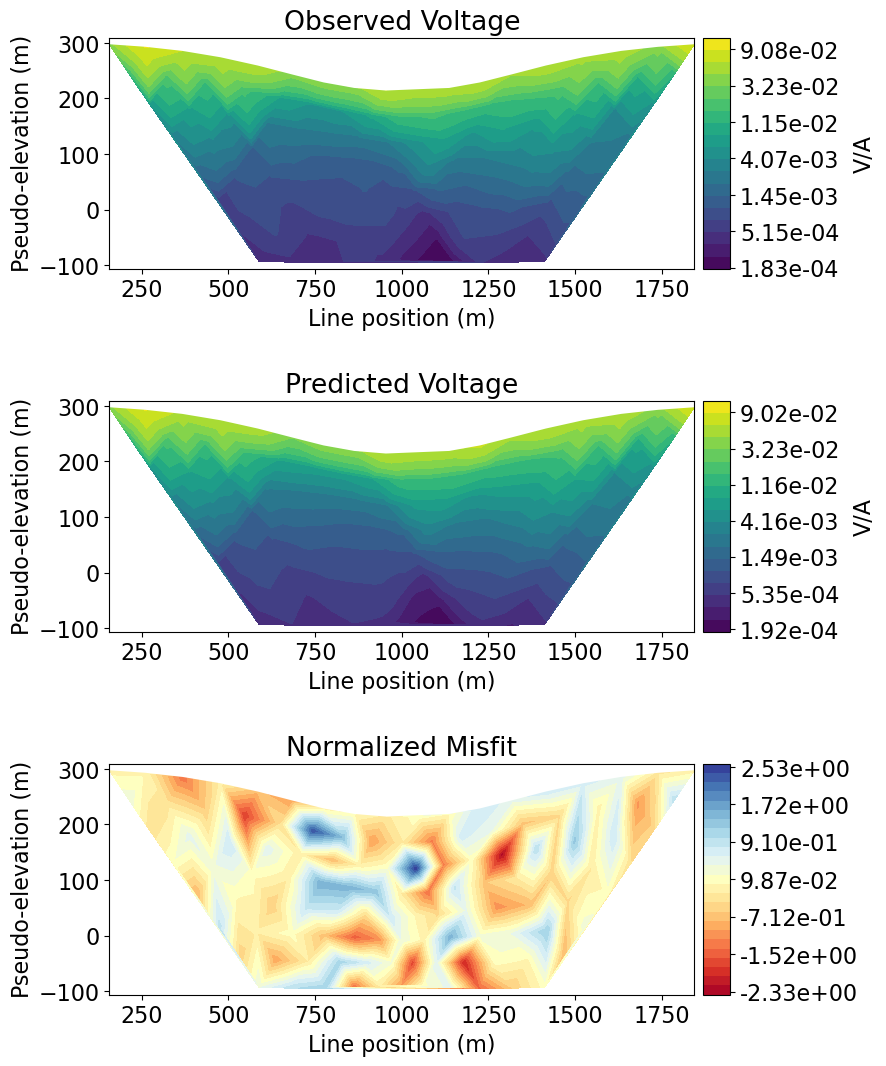

In [26]:
# Data associated with the line index provided
line_index = 0
k = lineID == line_index + 1
data_array = [
    np.abs(dc_data.dobs[k]),
    np.abs(dpred_dc[k]),
    (dc_data.dobs[k] - dpred_dc[k]) / dc_data.standard_deviation[k],
]

# Plot 2D pseudosections (observed, predicted, normalized misfit)
fig = plt.figure(figsize=(9, 11))
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        survey_2d_list[line_index],
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### Plot True and Recovered Conductivity Model

In [27]:
# Define conductivity model in S/m
background_value = 1e-2
conductor_value = 1e-1
resistor_value = 1e-3

# Define true model
true_conductivity_model = background_value * np.ones(n_active)

ind_conductor = model_builder.get_indices_sphere(
    np.r_[-300.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_conductor] = conductor_value

ind_resistor = model_builder.get_indices_sphere(
    np.r_[300.0, 0.0, 100.0], 160.0, mesh.cell_centers[active_cells, :]
)
true_conductivity_model[ind_resistor] = resistor_value

In [28]:
# Convert log-conductivities to conductivities
recovered_conductivity_L2 = np.exp(recovered_log_conductivity_model)

In [29]:
# Define a mapping to ignore inactive cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

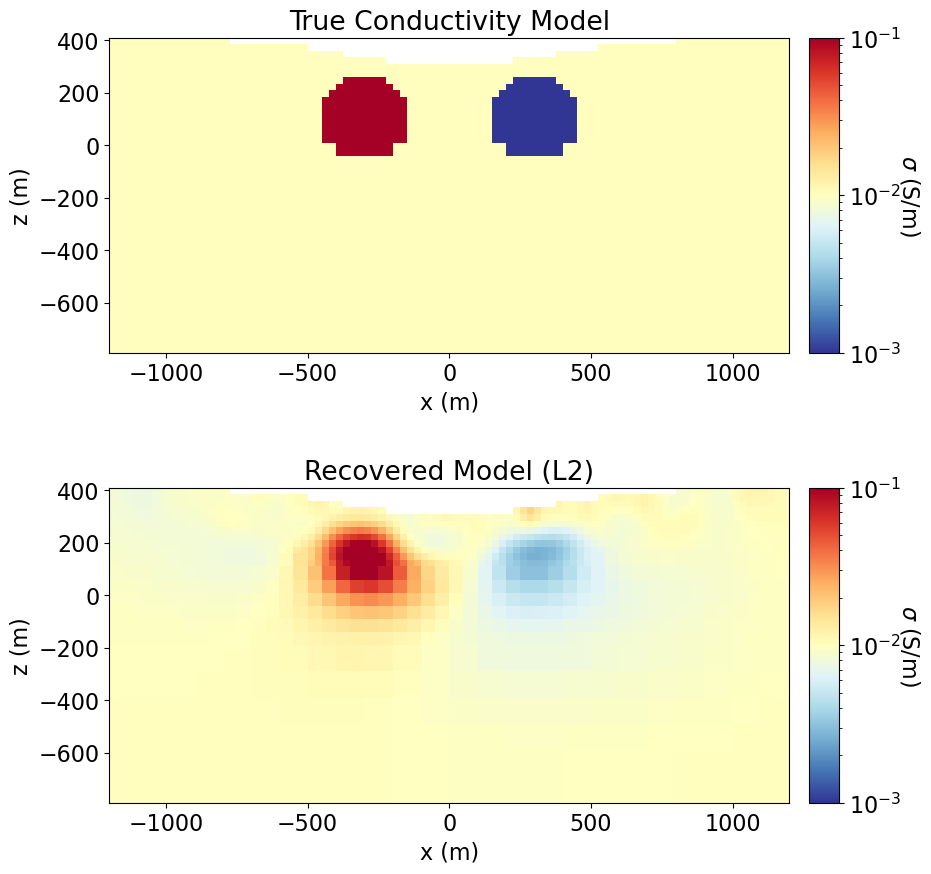

In [30]:
norm = LogNorm(vmin=1e-3, vmax=1e-1)

fig = plt.figure(figsize=(10, 9))
ax1 = 2 * [None]
ax2 = 2 * [None]
cbar = 2 * [None]
title_str = [
    "True Conductivity Model",
    "Recovered Model (L2)",
]
plotting_model = [
    true_conductivity_model,
    recovered_conductivity_L2,
]

for ii in range(0, 2):
    ax1[ii] = fig.add_axes([0.14, 0.6 - 0.5 * ii, 0.68, 0.35])

    temp = plotting_map * plotting_model[ii]

    mesh.plot_slice(
        temp,
        ax=ax1[ii],
        normal="Y",
        ind=int(len(mesh.h[1]) / 2),
        grid=False,
        pcolor_opts={"cmap": mpl.cm.RdYlBu_r, "norm": norm},
    )
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("z (m)")
    ax1[ii].set_xlim([-1200, 1200])
    ax1[ii].set_ylim([topo_xyz[:, -1].max() - 1200, topo_xyz[:, -1].max()])

    ax2[ii] = fig.add_axes([0.84, 0.6 - 0.5 * ii, 0.03, 0.35])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar[ii].set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=16)